# A Basic Model From Built in Modules

Here I explore the same data I used for my "from scratch" exercises to play with build in models provied by PyTorch.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.optim as optim
import torch.nn as nn

## The Data

For this exercies I generated some "known" measurments in Celcius, along with some measurments in "uknown" units.

My goal wil be to build a machine learning model from scratch that will illustrate how the process works to learn a pattern from this data to create a model.

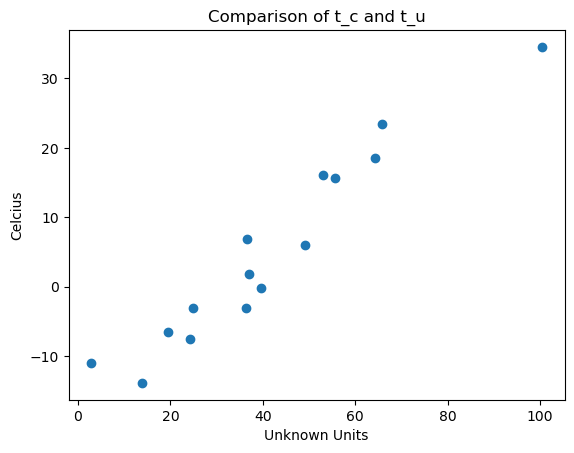

In [2]:
def simulate_temperature_data(random_state=111, num_pts=15):
    ## Simulate a set of num_pts measurments with
    ## t_c being a "known" celcius value and
    ## t_u being the measurments in "uknown" units (Farenheit with noise)
    
    rng = np.random.RandomState(random_state)
    ## Generate some celcius temps between -15 and 50 
    t_c = rng.rand(num_pts) * 50 - 15
    ## Generate corresponsing data in "unknown" units
    #°F = (°C × 9/5) + 32 + noise
    noise = rng.rand(num_pts)*20 - 10
    t_u = t_c*(9/5) + 32 + noise

    return t_c, t_u

## Generate data
t_c, t_u = simulate_temperature_data()
## Plot the data
plt.scatter(t_u,t_c)
plt.xlabel("Unknown Units")
plt.ylabel("Celcius")
plt.title("Comparison of t_c and t_u")
plt.show()

In [3]:
## Prepare the data
def prepare_data(t_c, t_u, valid_pct=0.2):
    ## Takes the t_c, t_u numpy arrays
    ## Returns a set of PyTorch arrays for training and validation
    ## Sets aside valid_pct of the data for validation
    t_c = torch.tensor(t_c).to(torch.float32).unsqueeze(1)
    t_u = torch.tensor(t_u).to(torch.float32).unsqueeze(1)
    
    ## Scale the input data
    t_un = 0.1*t_u

    ## Get the number of samples
    n_samples = t_u.shape[0]

    ## Determine the size of the validation set
    n_val = int(valid_pct*n_samples)

    ## Grab n_val random indices
    shuffled_indices = torch.randperm(n_samples)
    train_indices = shuffled_indices[:-n_val]
    val_indices = shuffled_indices[-n_val:]

    ## Gather up training and validation sets
    t_c_train = t_c[train_indices]
    t_c_val = t_c[val_indices]
    
    t_u_train = t_u[train_indices]
    t_u_val = t_u[val_indices]
    
    t_un_train = t_un[train_indices]
    t_un_val = t_un[val_indices]

    return (t_c_train, t_c_val, 
            t_u_train, t_u_val, 
            t_un_train, t_un_val)
    
t_c_train, t_c_val, t_u_train,\
    t_u_val, t_un_train, t_un_val = prepare_data(t_c, t_u)

## A Linear Model
As before, we use a linear model first.

In [4]:
## Insantiate the model, specifying inpyt/output dimension and data type
linear_model = nn.Linear(1,1)

## Evaluate the model on normalized inputs
linear_model(t_un_val)

tensor([[2.7863],
        [4.1069],
        [3.7993]], grad_fn=<AddmmBackward0>)

In [5]:
## Peek at weights and bias
linear_model.weight, linear_model.bias

(Parameter containing:
 tensor([[0.7899]], requires_grad=True),
 Parameter containing:
 tensor([-0.0812], requires_grad=True))

In [6]:
linear_model.parameters??

Signature: linear_model.parameters(recurse: bool = True) -> Iterator[torch.nn.parameter.Parameter]
Source:   
    def parameters(self, recurse: bool = True) -> Iterator[Parameter]:
        r"""Returns an iterator over module parameters.

        This is typically passed to an optimizer.

        Args:
            recurse (bool): if True, then yields parameters of this module
                and all submodules. Otherwise, yields only parameters that
                are direct members of this module.

        Yields:
            Parameter: module parameter

        Example::

            >>> # xdoctest: +SKIP("undefined vars")
            >>> for param in model.parameters():
            >>>     print(type(param), param.size())
            <class 'torch.Tensor'> (20L,)
            <class 'torch.Tensor'> (20L, 1L, 5L, 5L)

        """
        for name, param in self.named_parameters(recurse=recurse):
            yield param
File:      ~/miniconda3/envs/torch/lib/python3.11/site-packages/to

In [7]:
list(linear_model.parameters())

[Parameter containing:
 tensor([[0.7899]], requires_grad=True),
 Parameter containing:
 tensor([-0.0812], requires_grad=True)]

## Set up a training loop

In [8]:
def training_loop(n_epochs,
                  optimizer, model, loss_fn, 
                  t_u_train, t_u_val,
                  t_c_train, t_c_val):
    for epoch in range(1, n_epochs+1):
        ## Training set
        t_p_train = model(t_u_train) ## Make a prediction
        loss_train = loss_fn(t_p_train, t_c_train) ## Compute the loss

        ## Validation set
        t_p_val = model(t_u_val) ## Make a predicton
        loss_val = loss_fn(t_p_val, t_c_val) ## Compute the loss

        ## Update params
        optimizer.zero_grad() ## Reset accumulated gradient
        loss_train.backward() ## Update the gradient at the training input
        optimizer.step() ## Step the params in the direction of the gradient

        if (epoch <= 5) or (epoch % 500 == 0):
            print(f"Epoch: {epoch}, Training loss: {loss_train.item():.4f},"
                  f"Validation loss: {loss_val.item():.4f}")

In [9]:
## Define the model
linear_model = nn.Linear(1,1)

## Define an optimizer
optimizer = optim.SGD(
    linear_model.parameters(), ## What to optimize
    lr = 1e-2 ## Learning rate
)

## Train the model
training_loop(n_epochs = 5000,
              optimizer = optimizer,
              model = linear_model, 
              loss_fn = nn.MSELoss(), ## Use a built in loss function 
              t_u_train = t_un_train, 
              t_u_val = t_un_val,
              t_c_train = t_c_train, 
              t_c_val = t_c_val)

print()
print(linear_model.weight)
print(linear_model.bias)

Epoch: 1, Training loss: 282.7591,Validation loss: 134.5507
Epoch: 2, Training loss: 147.8821,Validation loss: 55.9327
Epoch: 3, Training loss: 110.1287,Validation loss: 46.4158
Epoch: 4, Training loss: 99.0598,Validation loss: 50.0000
Epoch: 5, Training loss: 95.3282,Validation loss: 54.1151
Epoch: 500, Training loss: 11.2041,Validation loss: 23.1057
Epoch: 1000, Training loss: 10.9125,Validation loss: 21.6460
Epoch: 1500, Training loss: 10.9115,Validation loss: 21.5646
Epoch: 2000, Training loss: 10.9115,Validation loss: 21.5599
Epoch: 2500, Training loss: 10.9115,Validation loss: 21.5599
Epoch: 3000, Training loss: 10.9115,Validation loss: 21.5599
Epoch: 3500, Training loss: 10.9115,Validation loss: 21.5599
Epoch: 4000, Training loss: 10.9115,Validation loss: 21.5599
Epoch: 4500, Training loss: 10.9115,Validation loss: 21.5599
Epoch: 5000, Training loss: 10.9115,Validation loss: 21.5599

Parameter containing:
tensor([[5.4151]], requires_grad=True)
Parameter containing:
tensor([-16.9

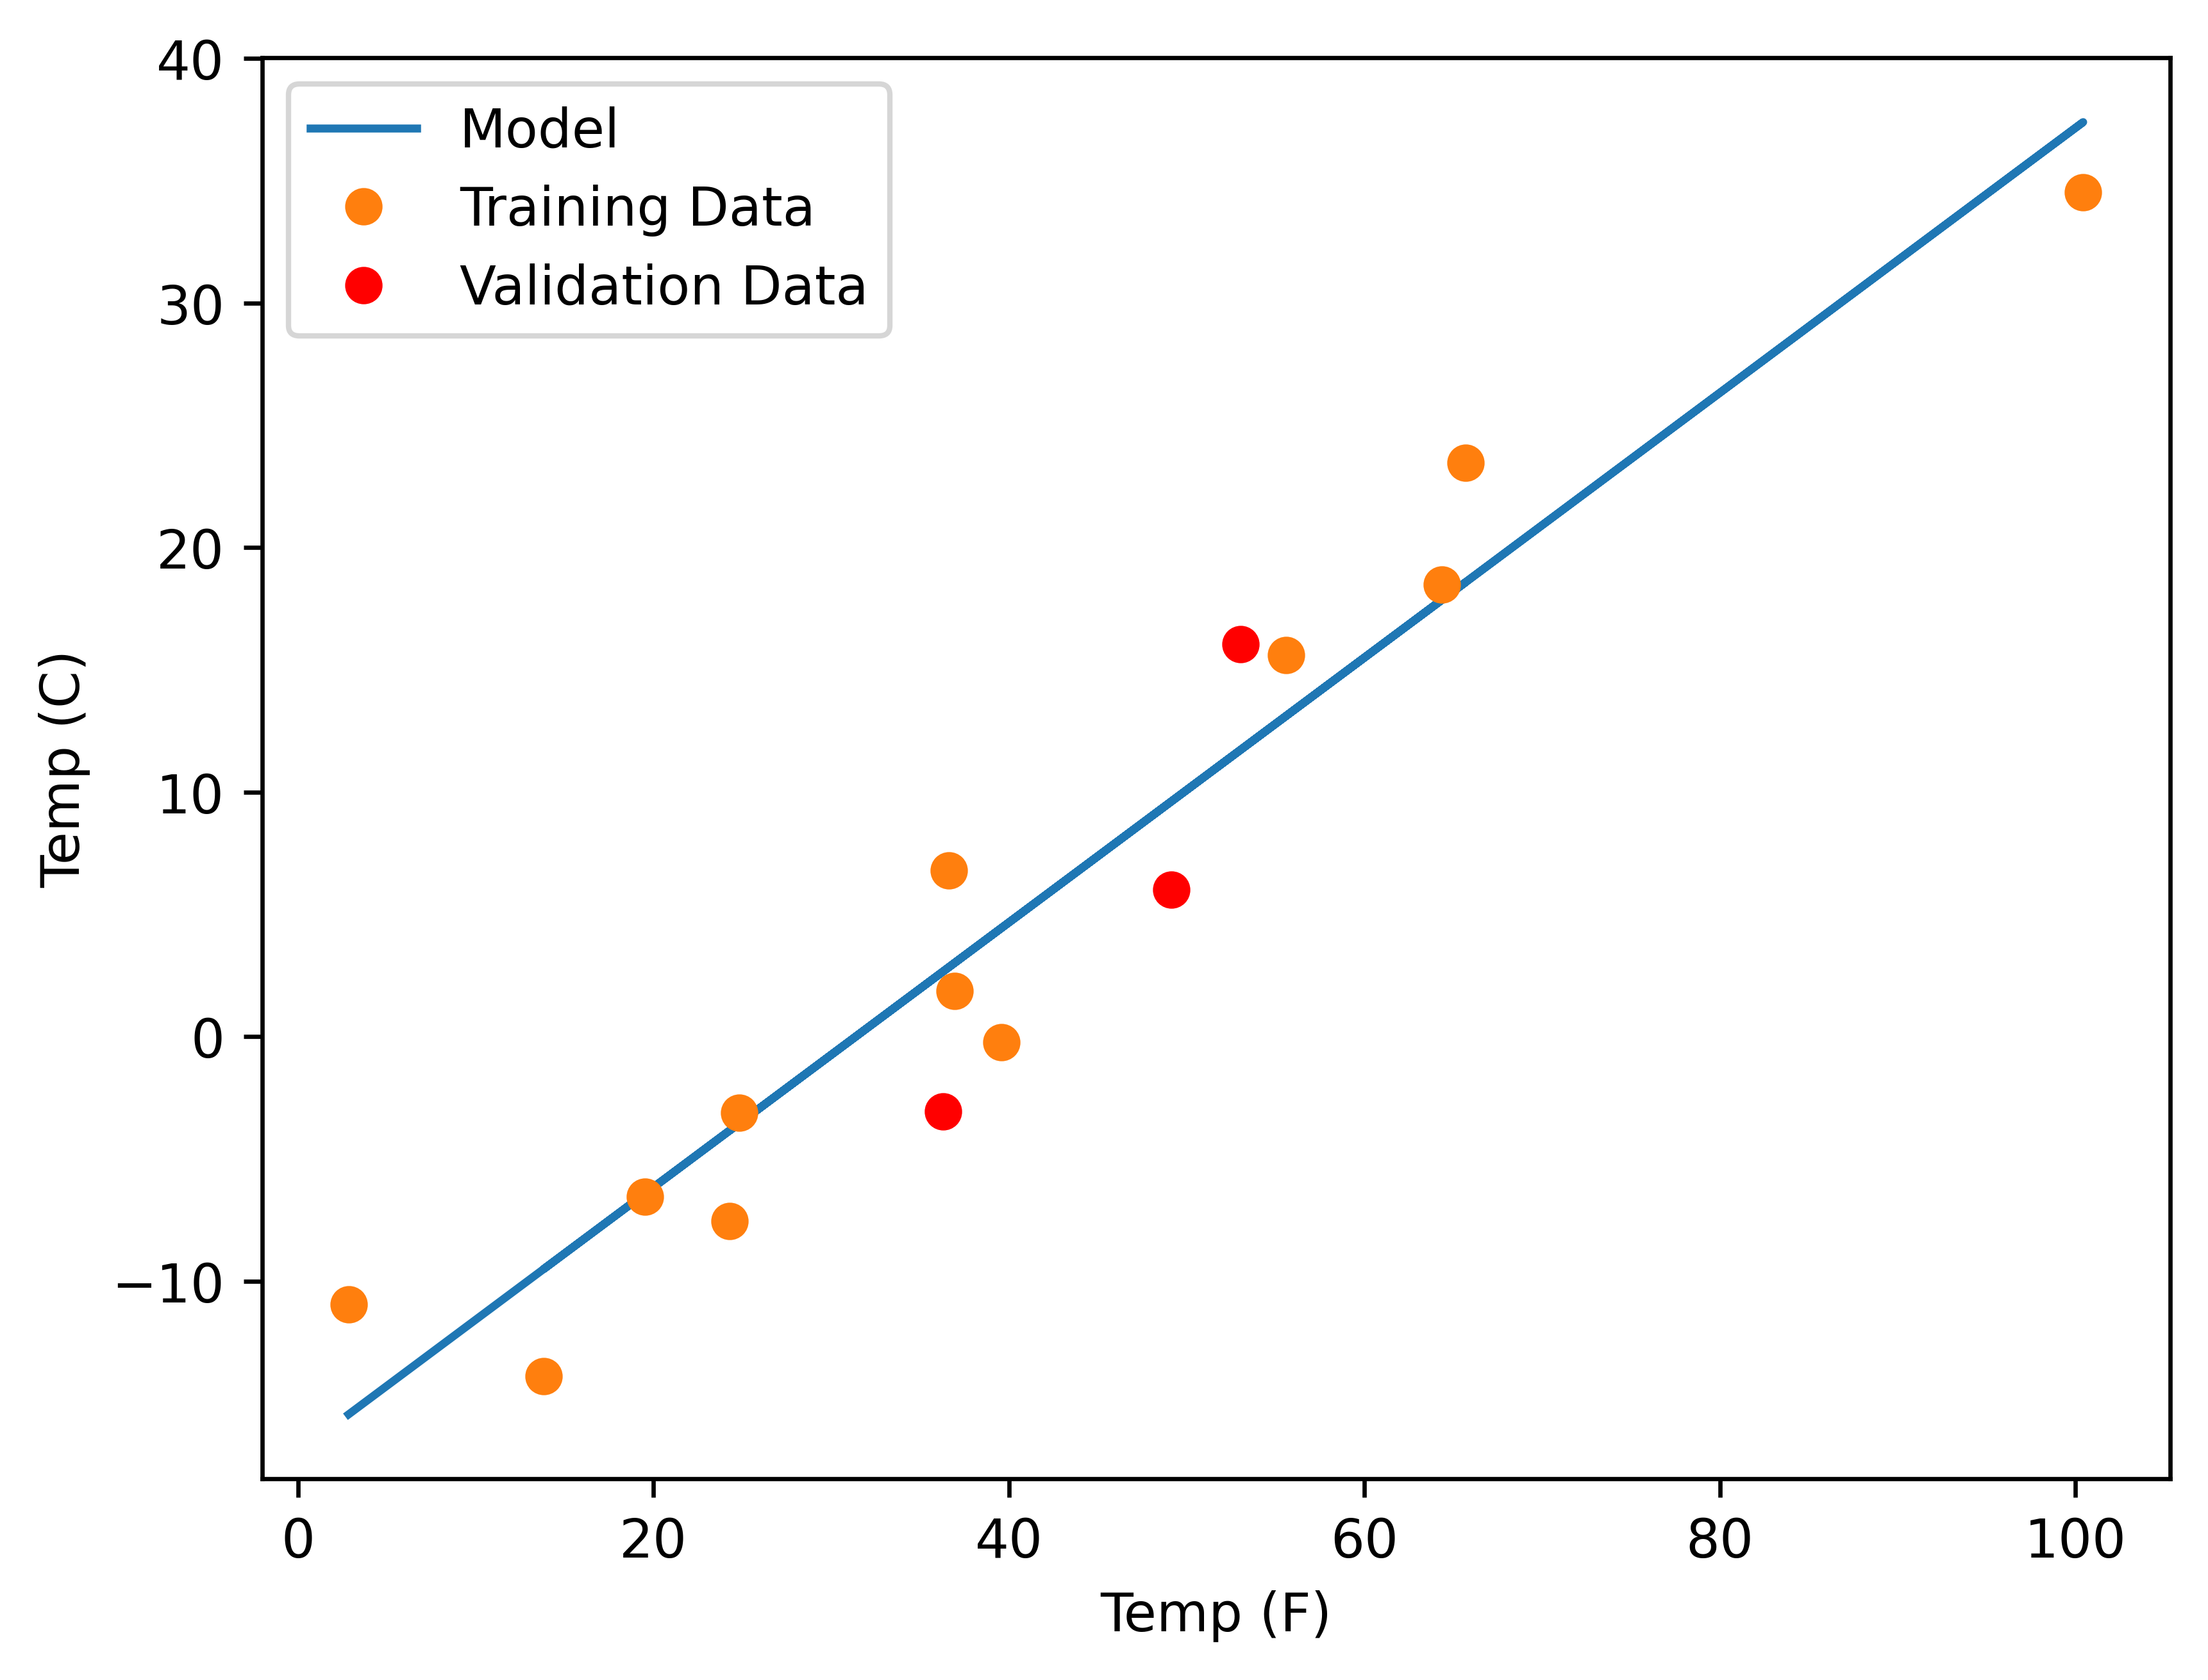

In [10]:
## Plot the results
t_p_train = linear_model(t_un_train)
fig = plt.figure(dpi=600)
plt.xlabel("Temp (F)")
plt.ylabel("Temp (C)")
plt.plot(t_u_train.numpy(), t_p_train.detach().numpy(), label="Model")
plt.plot(t_u_train.numpy(), t_c_train.numpy(), 'o', label="Training Data")
plt.plot(t_u_val.numpy(), t_c_val.numpy(), 'ro', label="Validation Data")
plt.legend()
plt.show()

## A Neural Network 

To this point, we've basically just been doing linear regression, the model was of the form
$$\hat{y}=wx+b$$

Now, we will introduce non-linearity into the model in the form a non-linear activation function.

In [11]:
seq_model = nn.Sequential(nn.Linear(1,13),  ## Define a linear input layer with 13 hidden units
                          nn.Tanh(), ## Use the hyperbolic tangent activation function
                          nn.Linear(13,1) ## Define the output layer to return a single output
                         )
seq_model

Sequential(
  (0): Linear(in_features=1, out_features=13, bias=True)
  (1): Tanh()
  (2): Linear(in_features=13, out_features=1, bias=True)
)

In [12]:
[param.shape for param in seq_model.parameters()]

[torch.Size([13, 1]), torch.Size([13]), torch.Size([1, 13]), torch.Size([1])]

In [13]:
[param.dtype for param in seq_model.parameters()]

[torch.float32, torch.float32, torch.float32, torch.float32]

In [14]:
t_un_val.dtype, t_un_val.shape

(torch.float32, torch.Size([3, 1]))

In [15]:
seq_model(t_un_val)

tensor([[-0.5469],
        [-0.5065],
        [-0.5111]], grad_fn=<AddmmBackward0>)

In [16]:
for name, param in seq_model.named_parameters():
    print(name, param.shape)

0.weight torch.Size([13, 1])
0.bias torch.Size([13])
2.weight torch.Size([1, 13])
2.bias torch.Size([1])


In [17]:
## Renaming our layers by construcing from an OrderedDict
from collections import OrderedDict
seq_model = nn.Sequential(OrderedDict([
    ('hidden_linear', nn.Linear(1, 8)),
    ('hidden_activation', nn.Tanh()),
    ('output_linear', nn.Linear(8, 1))
]))

In [18]:
seq_model

Sequential(
  (hidden_linear): Linear(in_features=1, out_features=8, bias=True)
  (hidden_activation): Tanh()
  (output_linear): Linear(in_features=8, out_features=1, bias=True)
)

In [19]:
seq_model.output_linear.weight, seq_model.output_linear.bias

(Parameter containing:
 tensor([[ 0.0292, -0.0869, -0.1787, -0.0371,  0.2485, -0.0255,  0.1674, -0.1397]],
        requires_grad=True),
 Parameter containing:
 tensor([-0.0119], requires_grad=True))

In [20]:
## Define an optimizer
optimizer = optim.SGD(
    seq_model.parameters(), ## What to optimize
    lr = 1e-3 ## Learning rate
)

## Train the model
training_loop(n_epochs = 5000,
              optimizer = optimizer,
              model = seq_model, 
              loss_fn = nn.MSELoss(), ## Use a built in loss function 
              t_u_train = t_un_train, 
              t_u_val = t_un_val,
              t_c_train = t_c_train, 
              t_c_val = t_c_val)

print('output', seq_model(t_un_val))
print('answer', t_c_val)
print('hidden', seq_model.hidden_linear.weight.grad)


Epoch: 1, Training loss: 236.9144,Validation loss: 105.6243
Epoch: 2, Training loss: 235.4124,Validation loss: 104.1144
Epoch: 3, Training loss: 233.9499,Validation loss: 102.6500
Epoch: 4, Training loss: 232.5256,Validation loss: 101.2297
Epoch: 5, Training loss: 231.1382,Validation loss: 99.8522
Epoch: 500, Training loss: 17.9626,Validation loss: 21.3458
Epoch: 1000, Training loss: 9.8287,Validation loss: 17.4059
Epoch: 1500, Training loss: 7.7517,Validation loss: 17.0223
Epoch: 2000, Training loss: 7.0008,Validation loss: 16.9219
Epoch: 2500, Training loss: 6.6532,Validation loss: 17.0325
Epoch: 3000, Training loss: 6.4477,Validation loss: 17.1857
Epoch: 3500, Training loss: 6.3050,Validation loss: 17.3277
Epoch: 4000, Training loss: 6.1981,Validation loss: 17.4490
Epoch: 4500, Training loss: 6.1154,Validation loss: 17.5490
Epoch: 5000, Training loss: 6.0507,Validation loss: 17.6294
output tensor([[ 2.0748],
        [12.3928],
        [ 9.6165]], grad_fn=<AddmmBackward0>)
answer ten

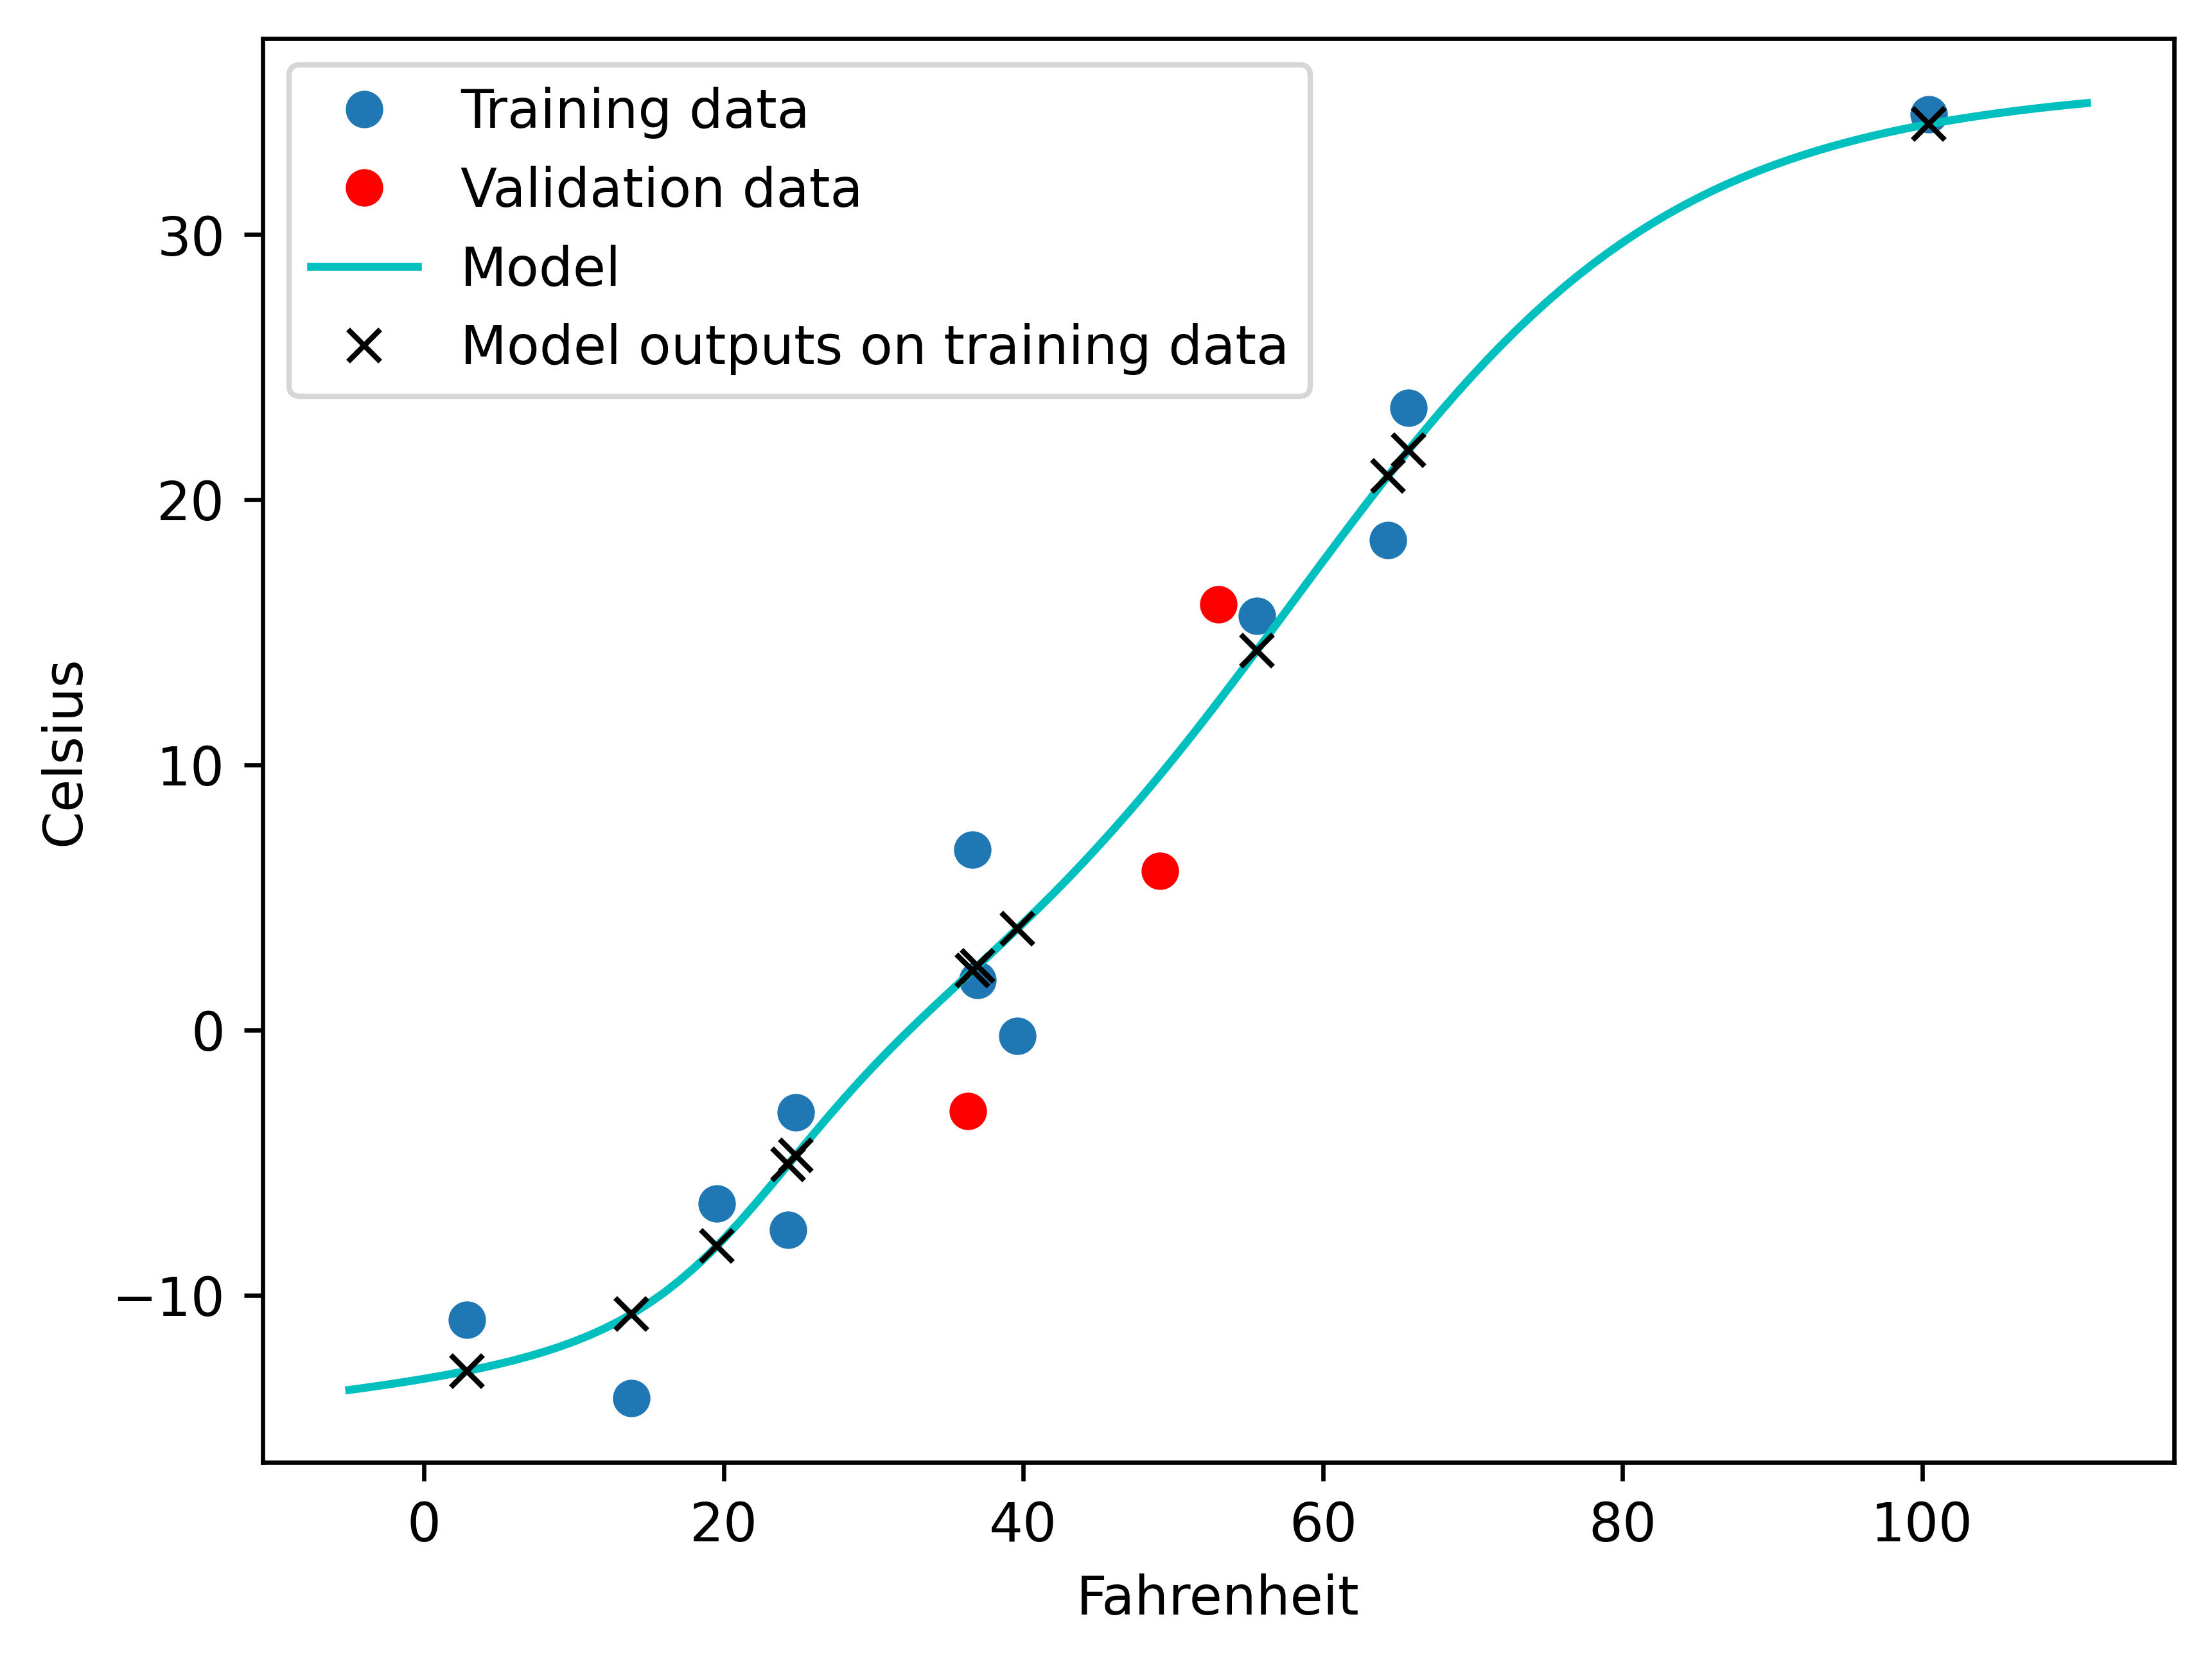

In [21]:
## Visiualizing the model
t_range = torch.arange(-5., 112.).unsqueeze(1) ## Grab temps between -5F and 112F
fig = plt.figure(dpi=600)
plt.xlabel("Fahrenheit")
plt.ylabel("Celsius")
plt.plot(t_u_train, t_c_train, 'o', label='Training data')
plt.plot(t_u_val, t_c_val, 'or', label='Validation data')
plt.plot(t_range.numpy(), seq_model(0.1 * t_range).detach().numpy(), 'c-', label='Model')
plt.plot(t_u_train, seq_model(t_un_train).detach().numpy(), 'kx', label='Model outputs on training data')
plt.legend()
plt.show()

## Messing around with choices...

Epoch: 1, Training loss: 248.0512,Validation loss: 116.8311
Epoch: 2, Training loss: 244.9845,Validation loss: 114.2038
Epoch: 3, Training loss: 242.0044,Validation loss: 111.6680
Epoch: 4, Training loss: 239.1645,Validation loss: 109.2361
Epoch: 5, Training loss: 236.4918,Validation loss: 106.9171
Epoch: 500, Training loss: 13.0460,Validation loss: 21.8531
Epoch: 1000, Training loss: 8.3918,Validation loss: 18.1128
Epoch: 1500, Training loss: 7.3631,Validation loss: 16.7874
Epoch: 2000, Training loss: 7.0713,Validation loss: 16.4344
Epoch: 2500, Training loss: 6.9525,Validation loss: 16.5083
Epoch: 3000, Training loss: 6.8692,Validation loss: 16.7929
Epoch: 3500, Training loss: 6.7776,Validation loss: 16.9554
Epoch: 4000, Training loss: 6.7026,Validation loss: 16.9864
Epoch: 4500, Training loss: 6.6315,Validation loss: 17.0163
Epoch: 5000, Training loss: 6.5624,Validation loss: 17.0463


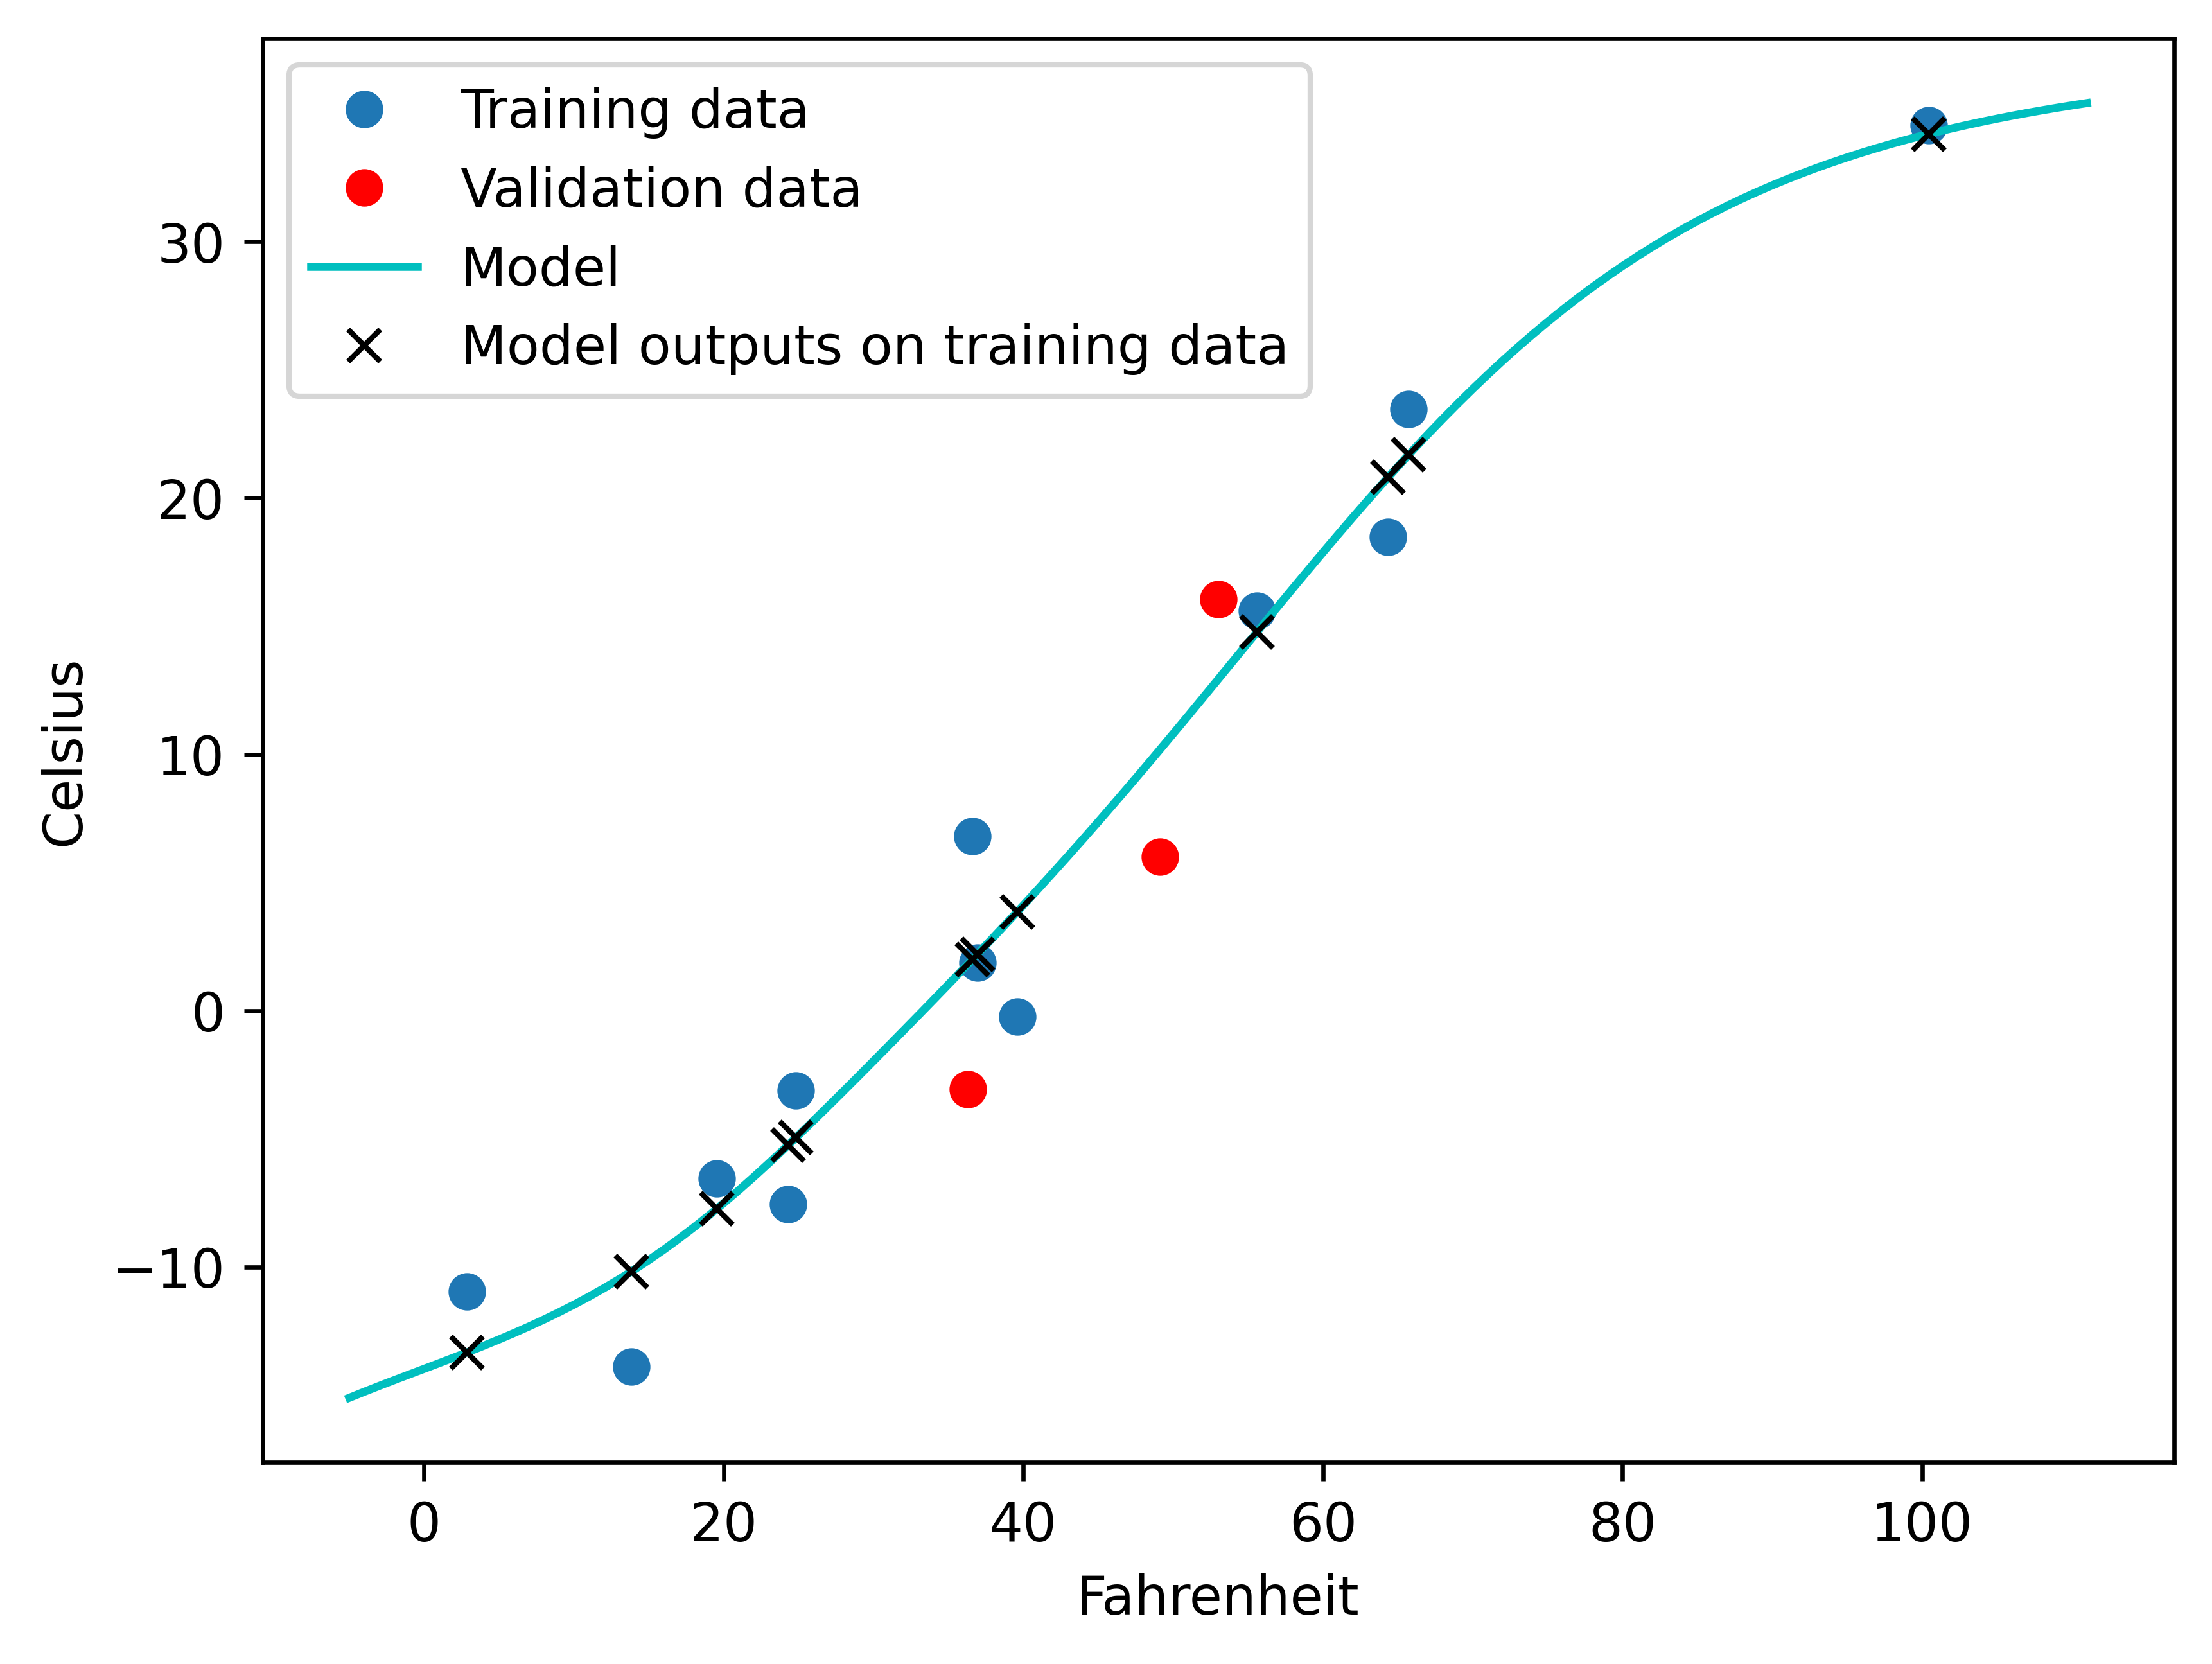

In [22]:
## Define a model
seq_model = nn.Sequential(nn.Linear(1,13),  ## Define a linear input layer with 13 hidden units
                          nn.Tanh(), ## Use the hyperbolic tangent activation function
                          nn.Linear(13,1) ## Define the output layer to return a single output
                         )

## Pick an optimizer and learning rate
optimizer = optim.SGD(
    seq_model.parameters(), ## What to optimize
    lr = 1e-3 ## Learning rate
)

## Train the model
training_loop(n_epochs = 5000,
              optimizer = optimizer,
              model = seq_model, 
              loss_fn = nn.MSELoss(), ## Use a built in loss function 
              t_u_train = t_un_train, 
              t_u_val = t_un_val,
              t_c_train = t_c_train, 
              t_c_val = t_c_val)

## Visiualizing the results
t_range = torch.arange(-5., 112.).unsqueeze(1) ## Grab temps between -5F and 112F
fig = plt.figure(dpi=600)
plt.xlabel("Fahrenheit")
plt.ylabel("Celsius")
plt.plot(t_u_train, t_c_train, 'o', label='Training data')
plt.plot(t_u_val, t_c_val, 'or', label='Validation data')
plt.plot(t_range.numpy(), seq_model(0.1 * t_range).detach().numpy(), 'c-', label='Model')
plt.plot(t_u_train, seq_model(t_un_train).detach().numpy(), 'kx', label='Model outputs on training data')
plt.legend()
plt.show()

Changing...

* Activation function

Epoch: 1, Training loss: 229.6013,Validation loss: 95.5189
Epoch: 2, Training loss: 210.3440,Validation loss: 84.8035
Epoch: 3, Training loss: 193.3938,Validation loss: 75.8193
Epoch: 4, Training loss: 178.0039,Validation loss: 68.1265
Epoch: 5, Training loss: 163.8715,Validation loss: 61.5225
Epoch: 500, Training loss: 9.5702,Validation loss: 19.5019
Epoch: 1000, Training loss: 8.8426,Validation loss: 18.8404
Epoch: 1500, Training loss: 8.6858,Validation loss: 18.9924
Epoch: 2000, Training loss: 8.5395,Validation loss: 19.1592
Epoch: 2500, Training loss: 8.3777,Validation loss: 19.5022
Epoch: 3000, Training loss: 8.1506,Validation loss: 20.3169
Epoch: 3500, Training loss: 8.0541,Validation loss: 20.6969
Epoch: 4000, Training loss: 7.9604,Validation loss: 21.0000
Epoch: 4500, Training loss: 7.8772,Validation loss: 21.3639
Epoch: 5000, Training loss: 7.8022,Validation loss: 21.7094


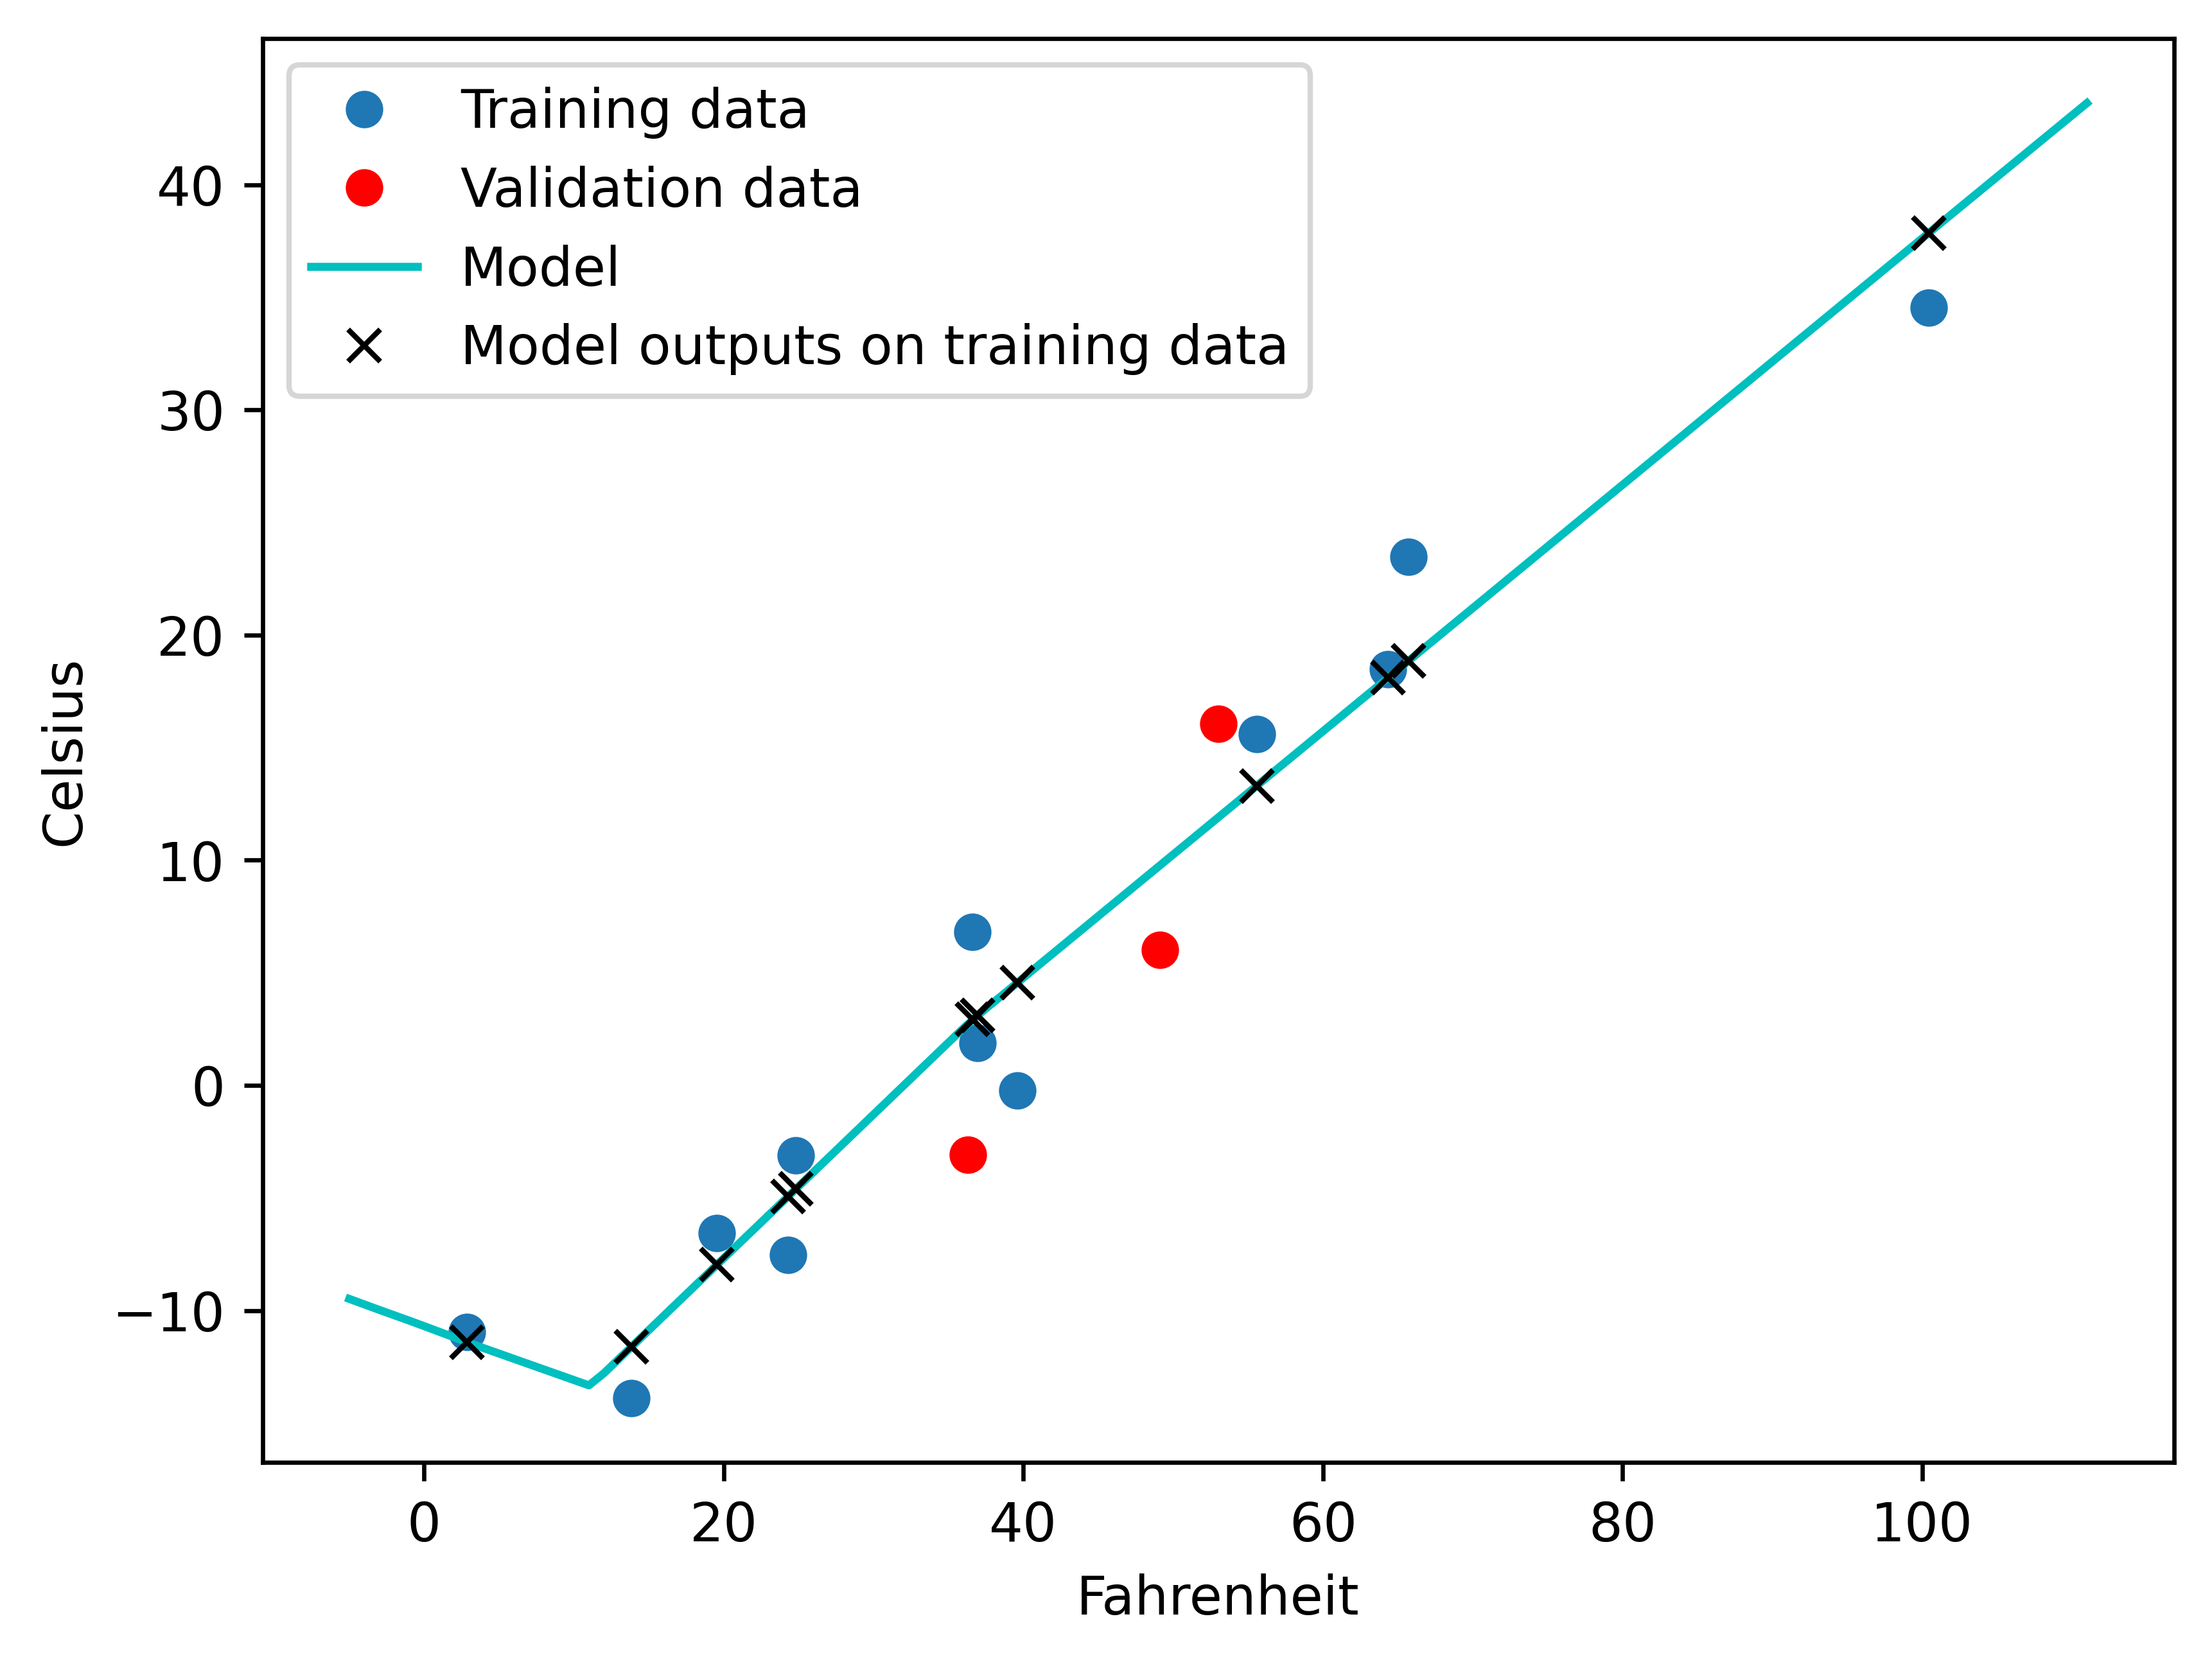

In [23]:
## Define a model
seq_model = nn.Sequential(nn.Linear(1,13),  ## Define a linear input layer with 13 hidden units
                          nn.ReLU(), ## Use the hyperbolic tangent activation function
                          nn.Linear(13,1) ## Define the output layer to return a single output
                         )

## Pick an optimizer and learning rate
optimizer = optim.SGD(
    seq_model.parameters(), ## What to optimize
    lr = 1e-3 ## Learning rate
)

## Train the model
training_loop(n_epochs = 5000,
              optimizer = optimizer,
              model = seq_model, 
              loss_fn = nn.MSELoss(), ## Use a built in loss function 
              t_u_train = t_un_train, 
              t_u_val = t_un_val,
              t_c_train = t_c_train, 
              t_c_val = t_c_val)

## Visiualizing the results
t_range = torch.arange(-5., 112.).unsqueeze(1) ## Grab temps between -5F and 112F
fig = plt.figure(dpi=600)
plt.xlabel("Fahrenheit")
plt.ylabel("Celsius")
plt.plot(t_u_train, t_c_train, 'o', label='Training data')
plt.plot(t_u_val, t_c_val, 'or', label='Validation data')
plt.plot(t_range.numpy(), seq_model(0.1 * t_range).detach().numpy(), 'c-', label='Model')
plt.plot(t_u_train, seq_model(t_un_train).detach().numpy(), 'kx', label='Model outputs on training data')
plt.legend()
plt.show()

Epoch: 1, Training loss: 227.9672,Validation loss: 95.4645
Epoch: 2, Training loss: 226.9715,Validation loss: 94.4451
Epoch: 3, Training loss: 226.0018,Validation loss: 93.4546
Epoch: 4, Training loss: 225.0573,Validation loss: 92.4919
Epoch: 5, Training loss: 224.1371,Validation loss: 91.5562
Epoch: 500, Training loss: 102.5649,Validation loss: 42.7848
Epoch: 1000, Training loss: 25.7856,Validation loss: 26.5895
Epoch: 1500, Training loss: 10.6314,Validation loss: 20.1063
Epoch: 2000, Training loss: 8.0258,Validation loss: 17.4653
Epoch: 2500, Training loss: 7.2805,Validation loss: 16.5700
Epoch: 3000, Training loss: 7.0007,Validation loss: 16.2902
Epoch: 3500, Training loss: 6.8754,Validation loss: 16.2637
Epoch: 4000, Training loss: 6.8093,Validation loss: 16.3465
Epoch: 4500, Training loss: 6.7684,Validation loss: 16.4726
Epoch: 5000, Training loss: 6.7393,Validation loss: 16.6141


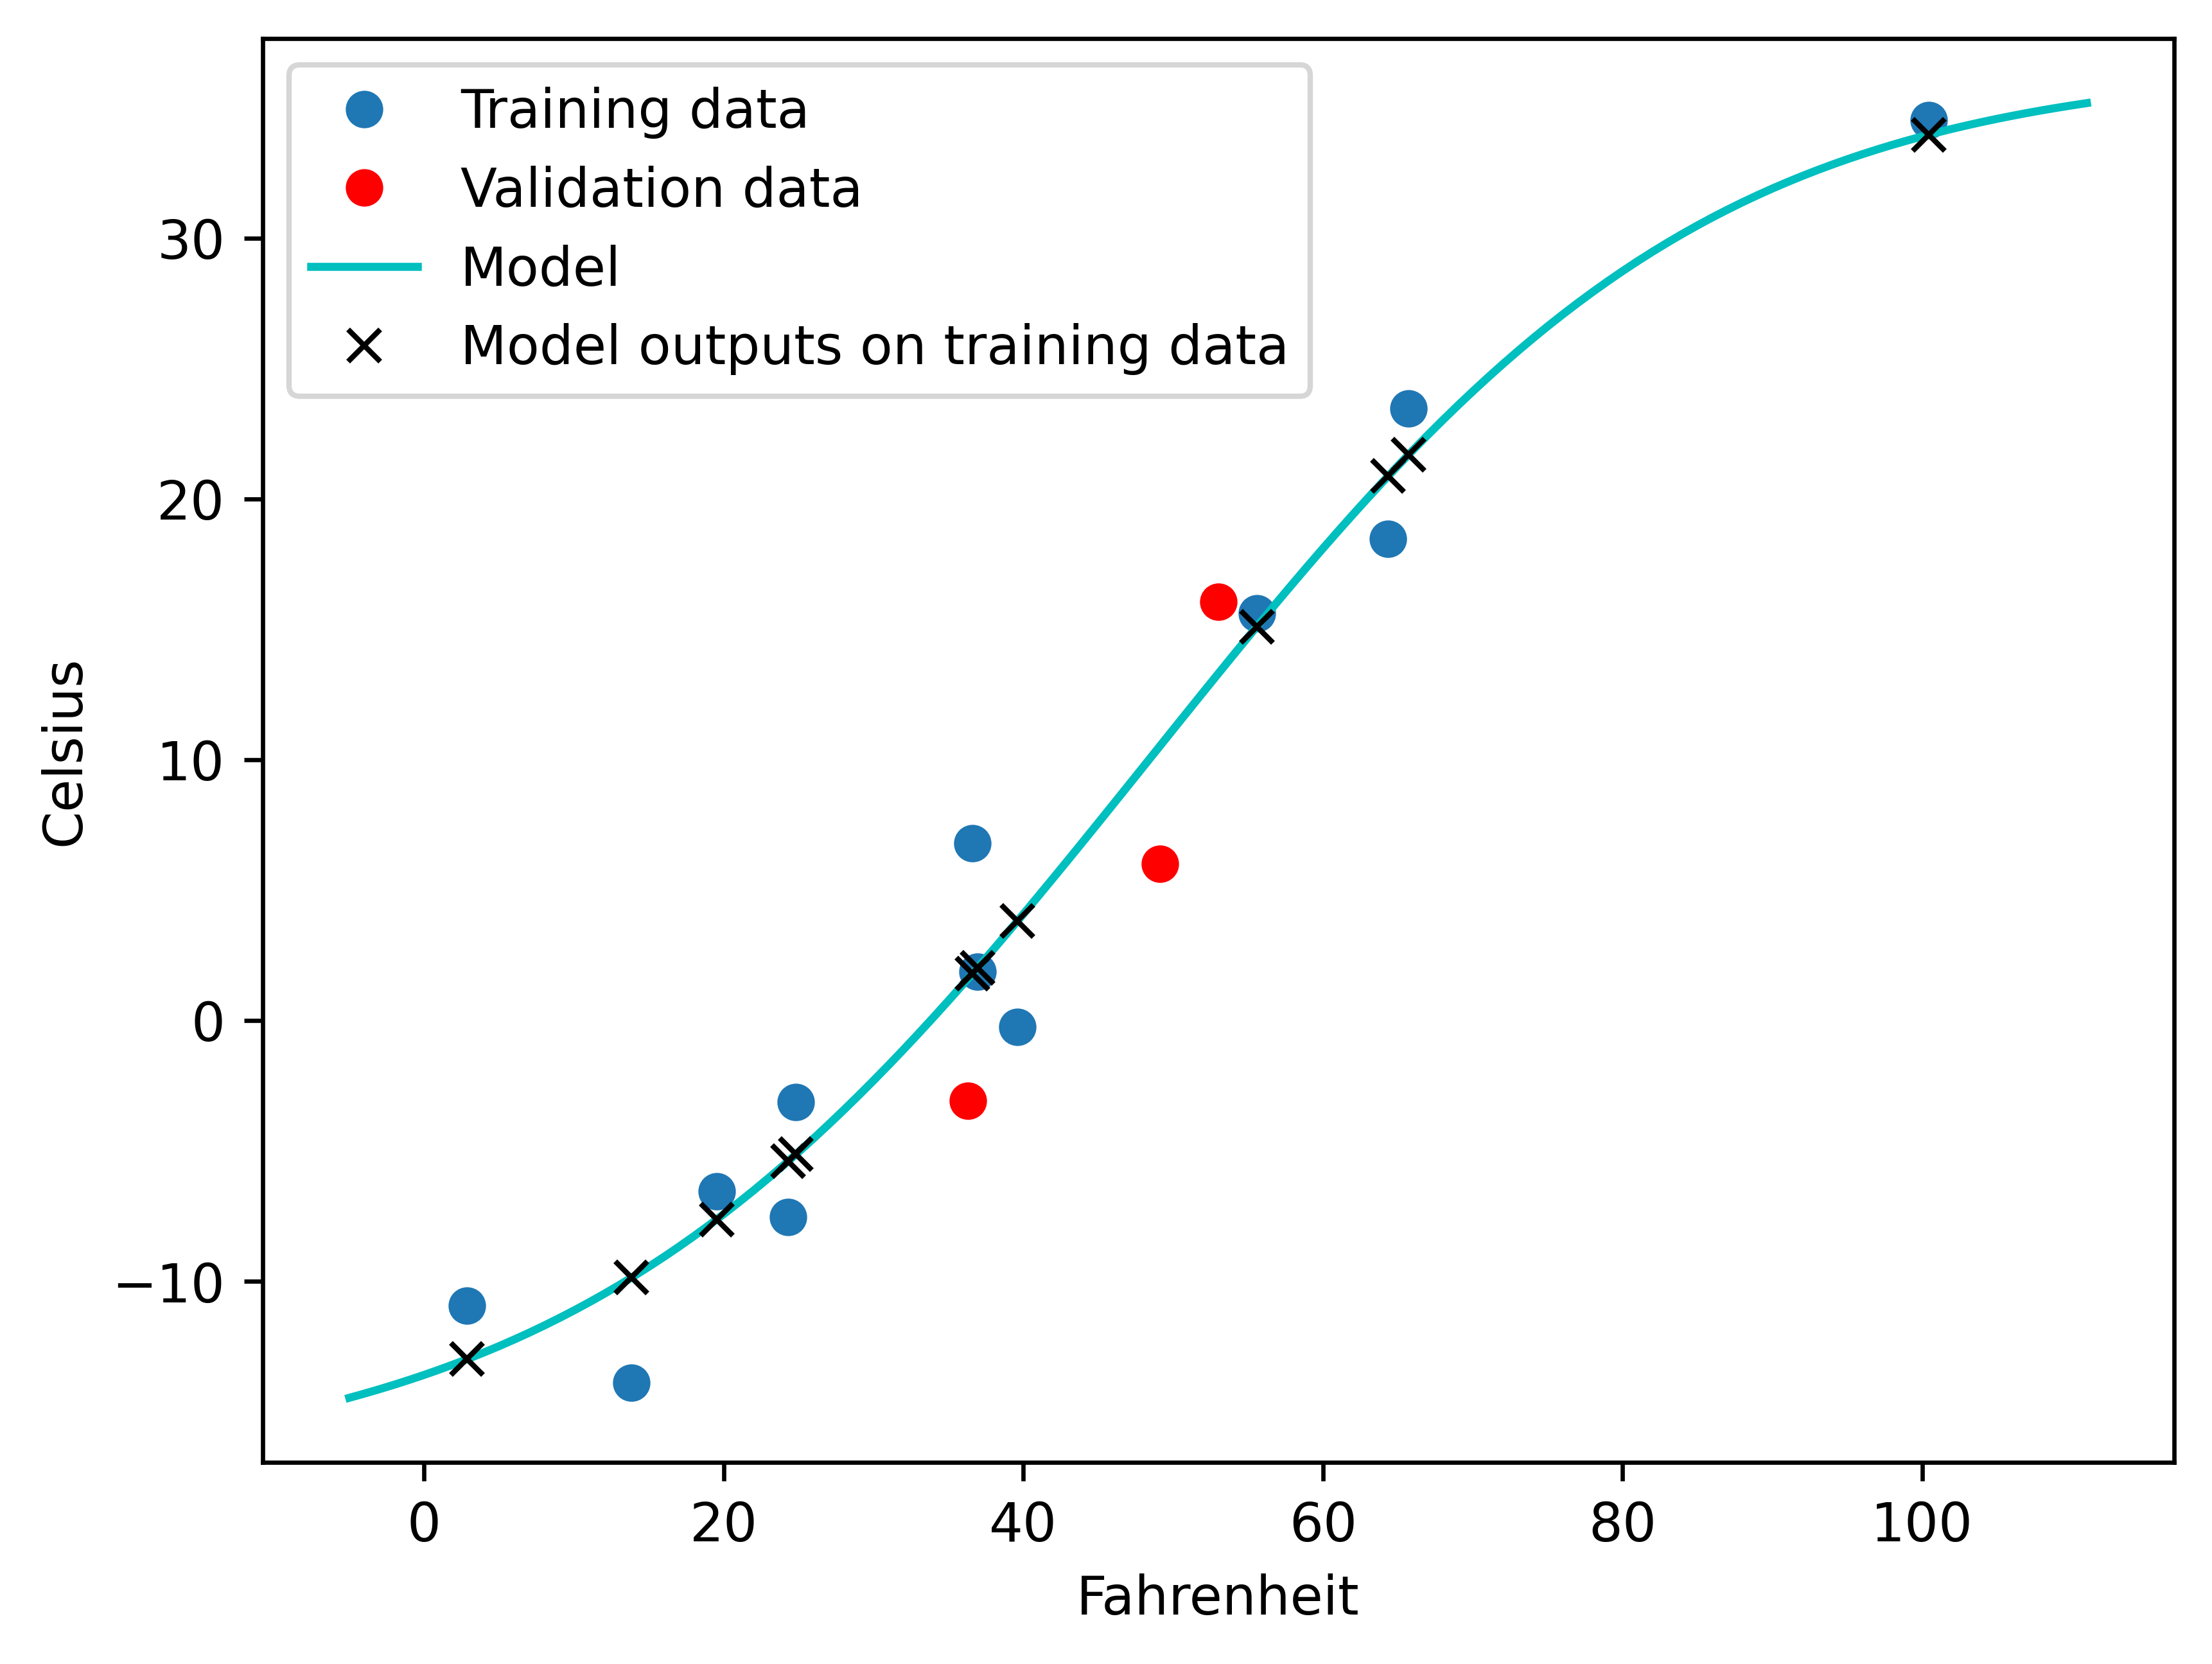

In [24]:
## Define a model
seq_model = nn.Sequential(nn.Linear(1,13),  ## Define a linear input layer with 13 hidden units
                          nn.Sigmoid(), ## Use the hyperbolic tangent activation function
                          nn.Linear(13,1) ## Define the output layer to return a single output
                         )

## Pick an optimizer and learning rate
optimizer = optim.SGD(
    seq_model.parameters(), ## What to optimize
    lr = 1e-3 ## Learning rate
)

## Train the model
training_loop(n_epochs = 5000,
              optimizer = optimizer,
              model = seq_model, 
              loss_fn = nn.MSELoss(), ## Use a built in loss function 
              t_u_train = t_un_train, 
              t_u_val = t_un_val,
              t_c_train = t_c_train, 
              t_c_val = t_c_val)

## Visiualizing the results
t_range = torch.arange(-5., 112.).unsqueeze(1) ## Grab temps between -5F and 112F
fig = plt.figure(dpi=600)
plt.xlabel("Fahrenheit")
plt.ylabel("Celsius")
plt.plot(t_u_train, t_c_train, 'o', label='Training data')
plt.plot(t_u_val, t_c_val, 'or', label='Validation data')
plt.plot(t_range.numpy(), seq_model(0.1 * t_range).detach().numpy(), 'c-', label='Model')
plt.plot(t_u_train, seq_model(t_un_train).detach().numpy(), 'kx', label='Model outputs on training data')
plt.legend()
plt.show()

Epoch: 1, Training loss: 235.7395,Validation loss: 106.0101
Epoch: 2, Training loss: 231.7160,Validation loss: 102.9235
Epoch: 3, Training loss: 227.9141,Validation loss: 100.0411
Epoch: 4, Training loss: 224.1719,Validation loss: 97.3089
Epoch: 5, Training loss: 220.3920,Validation loss: 94.6035
Epoch: 500, Training loss: 12.7389,Validation loss: 20.7902
Epoch: 1000, Training loss: 8.3843,Validation loss: 26.4080
Epoch: 1500, Training loss: 8.7159,Validation loss: 29.5565
Epoch: 2000, Training loss: 6.6461,Validation loss: 17.0697
Epoch: 2500, Training loss: 7.0169,Validation loss: 23.6070
Epoch: 3000, Training loss: 6.3019,Validation loss: 16.4416
Epoch: 3500, Training loss: 6.3906,Validation loss: 16.0615
Epoch: 4000, Training loss: 6.4346,Validation loss: 15.8199
Epoch: 4500, Training loss: 6.3941,Validation loss: 15.9196
Epoch: 5000, Training loss: 6.2852,Validation loss: 15.8410


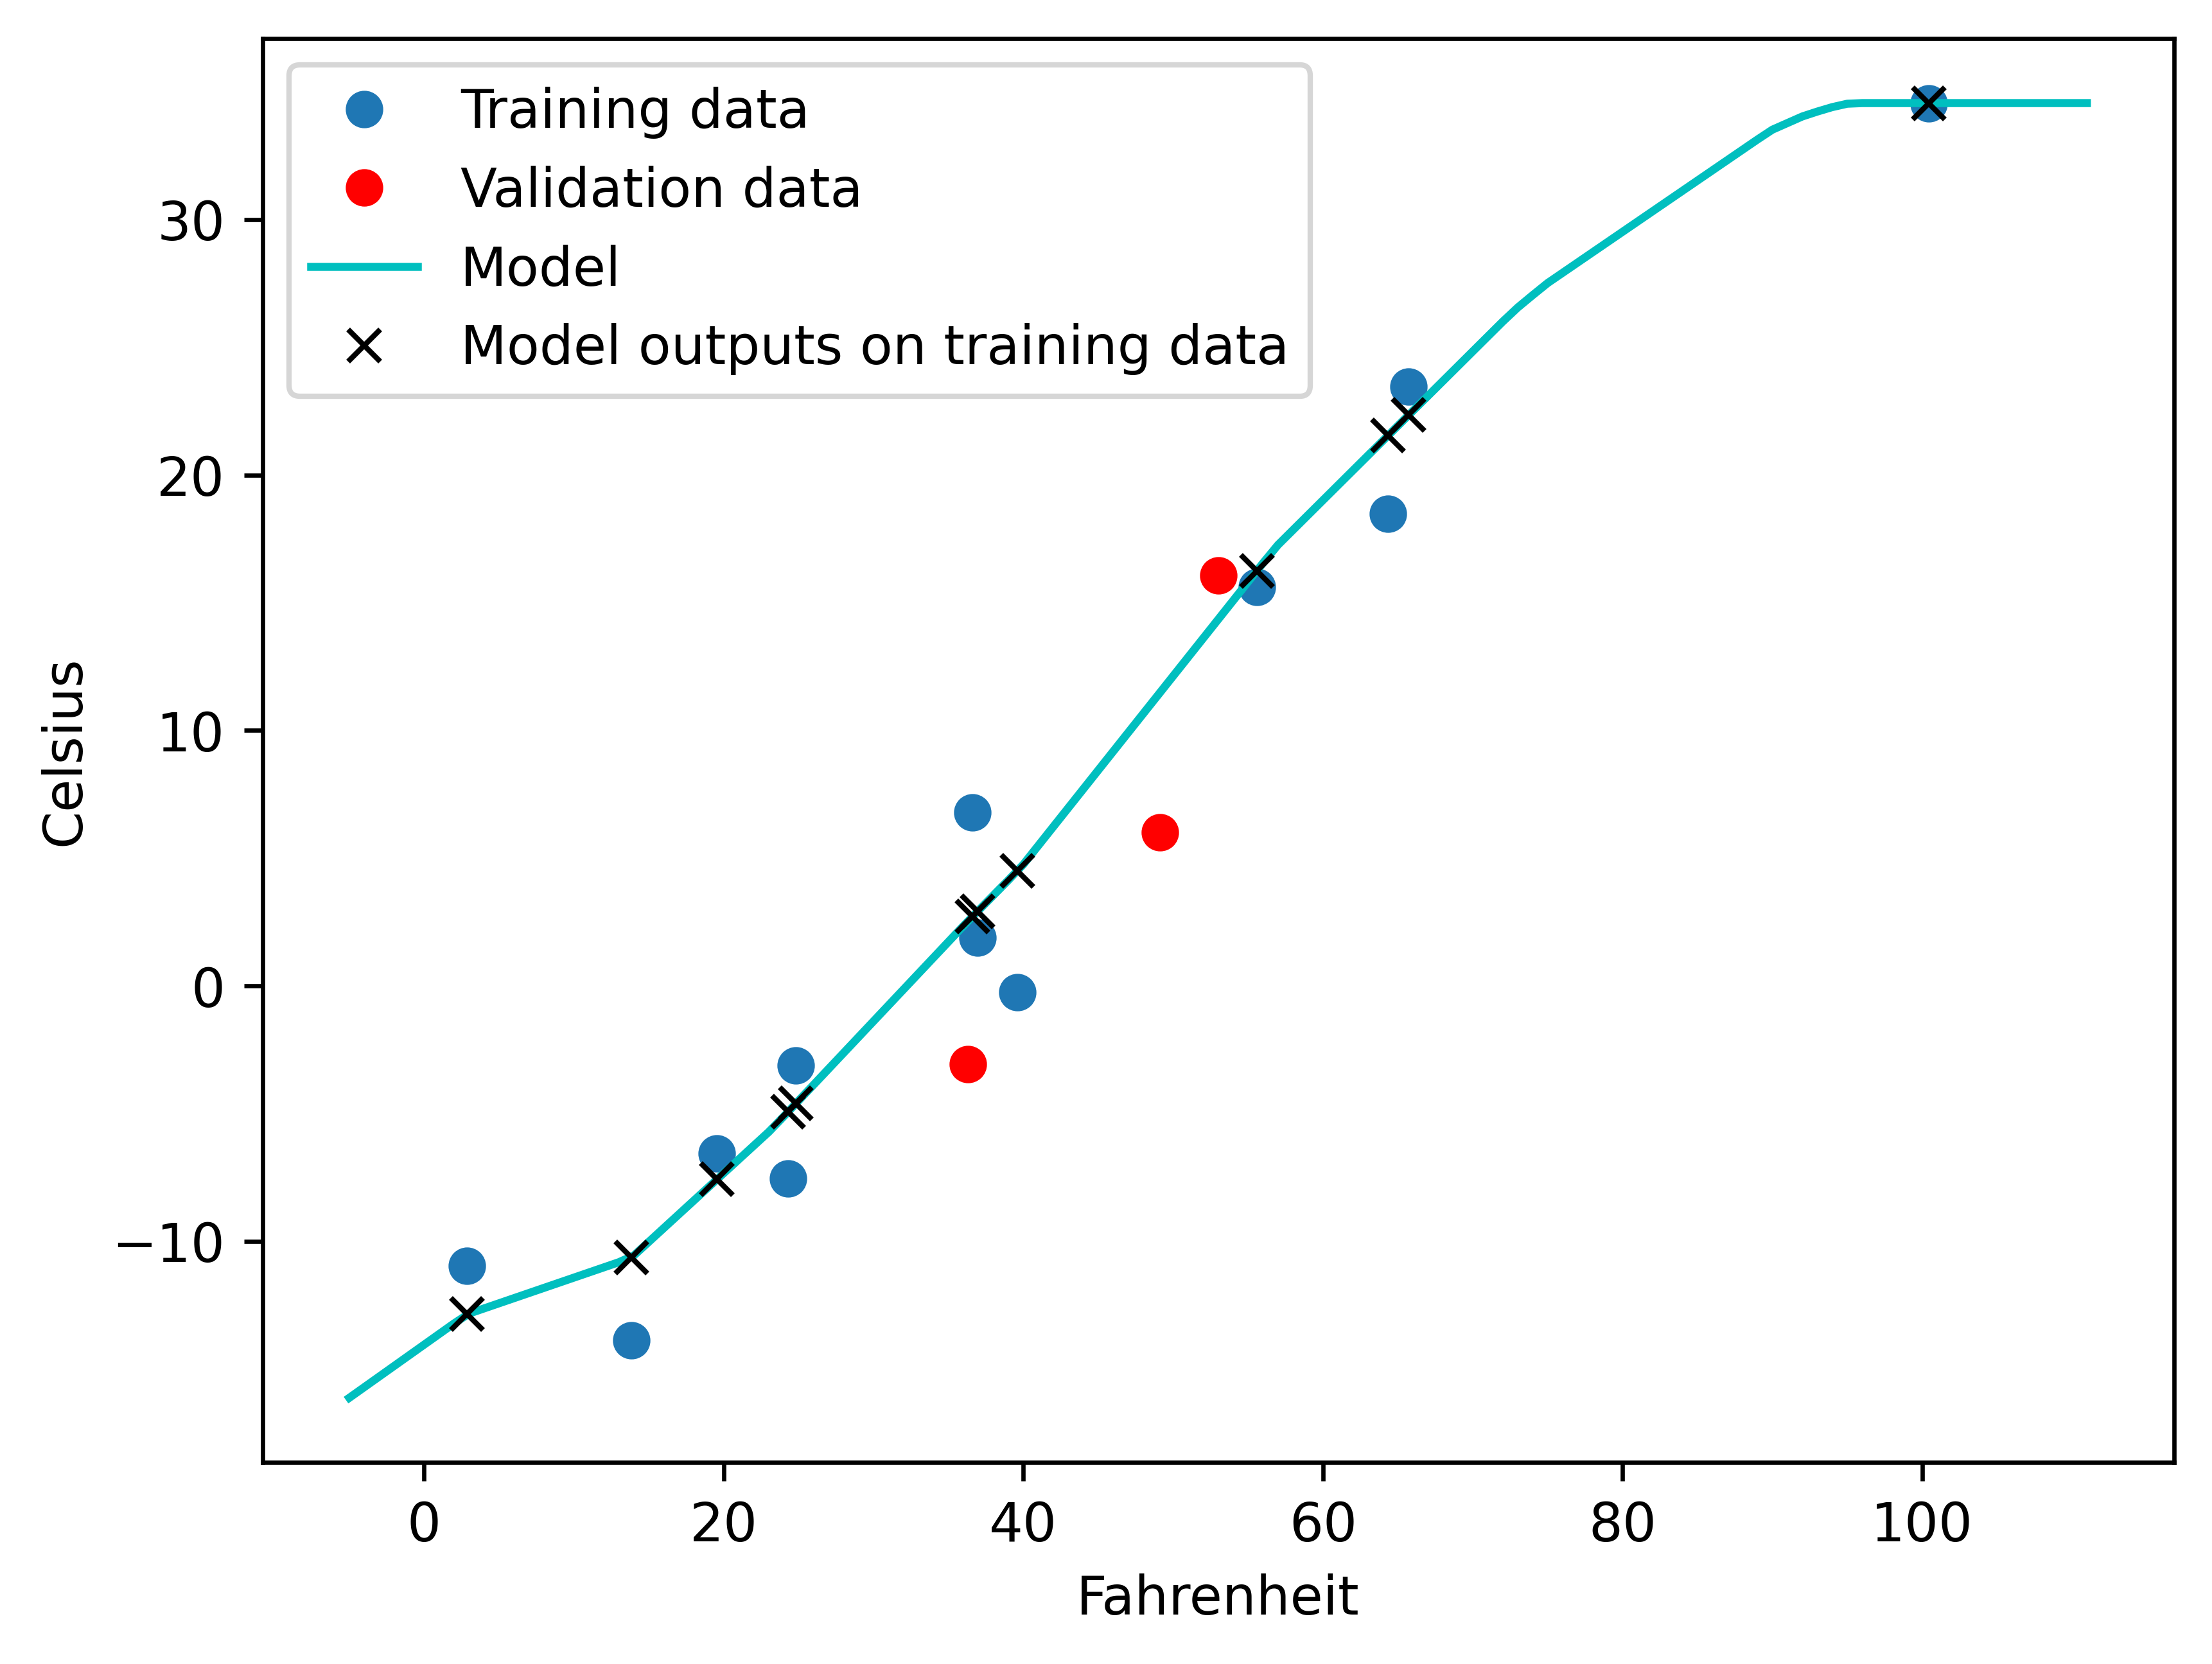

In [25]:
## Define a model
seq_model = nn.Sequential(nn.Linear(1,13),  ## Define a linear input layer with 13 hidden units
                          nn.Hardtanh(), ## Use the hyperbolic tangent activation function
                          nn.Linear(13,1) ## Define the output layer to return a single output
                         )

## Pick an optimizer and learning rate
optimizer = optim.SGD(
    seq_model.parameters(), ## What to optimize
    lr = 1e-3 ## Learning rate
)

## Train the model
training_loop(n_epochs = 5000,
              optimizer = optimizer,
              model = seq_model, 
              loss_fn = nn.MSELoss(), ## Use a built in loss function 
              t_u_train = t_un_train, 
              t_u_val = t_un_val,
              t_c_train = t_c_train, 
              t_c_val = t_c_val)

## Visiualizing the results
t_range = torch.arange(-5., 112.).unsqueeze(1) ## Grab temps between -5F and 112F
fig = plt.figure(dpi=600)
plt.xlabel("Fahrenheit")
plt.ylabel("Celsius")
plt.plot(t_u_train, t_c_train, 'o', label='Training data')
plt.plot(t_u_val, t_c_val, 'or', label='Validation data')
plt.plot(t_range.numpy(), seq_model(0.1 * t_range).detach().numpy(), 'c-', label='Model')
plt.plot(t_u_train, seq_model(t_un_train).detach().numpy(), 'kx', label='Model outputs on training data')
plt.legend()
plt.show()

### Number of layers

Epoch: 1, Training loss: 230.7837,Validation loss: 98.0798
Epoch: 2, Training loss: 229.4395,Validation loss: 96.7333
Epoch: 3, Training loss: 228.1377,Validation loss: 95.4330
Epoch: 4, Training loss: 226.8787,Validation loss: 94.1784
Epoch: 5, Training loss: 225.6618,Validation loss: 92.9686
Epoch: 500, Training loss: 16.0758,Validation loss: 14.3469
Epoch: 1000, Training loss: 10.4634,Validation loss: 17.2446
Epoch: 1500, Training loss: 6.9739,Validation loss: 16.8488
Epoch: 2000, Training loss: 5.8202,Validation loss: 16.6356
Epoch: 2500, Training loss: 5.3612,Validation loss: 16.3627
Epoch: 3000, Training loss: 5.1654,Validation loss: 16.2722
Epoch: 3500, Training loss: 5.0775,Validation loss: 16.3211
Epoch: 4000, Training loss: 5.0146,Validation loss: 16.3152
Epoch: 4500, Training loss: 4.9560,Validation loss: 16.3005
Epoch: 5000, Training loss: 4.8958,Validation loss: 16.2714
Epoch: 5500, Training loss: 4.8285,Validation loss: 16.2404
Epoch: 6000, Training loss: 4.7493,Validatio

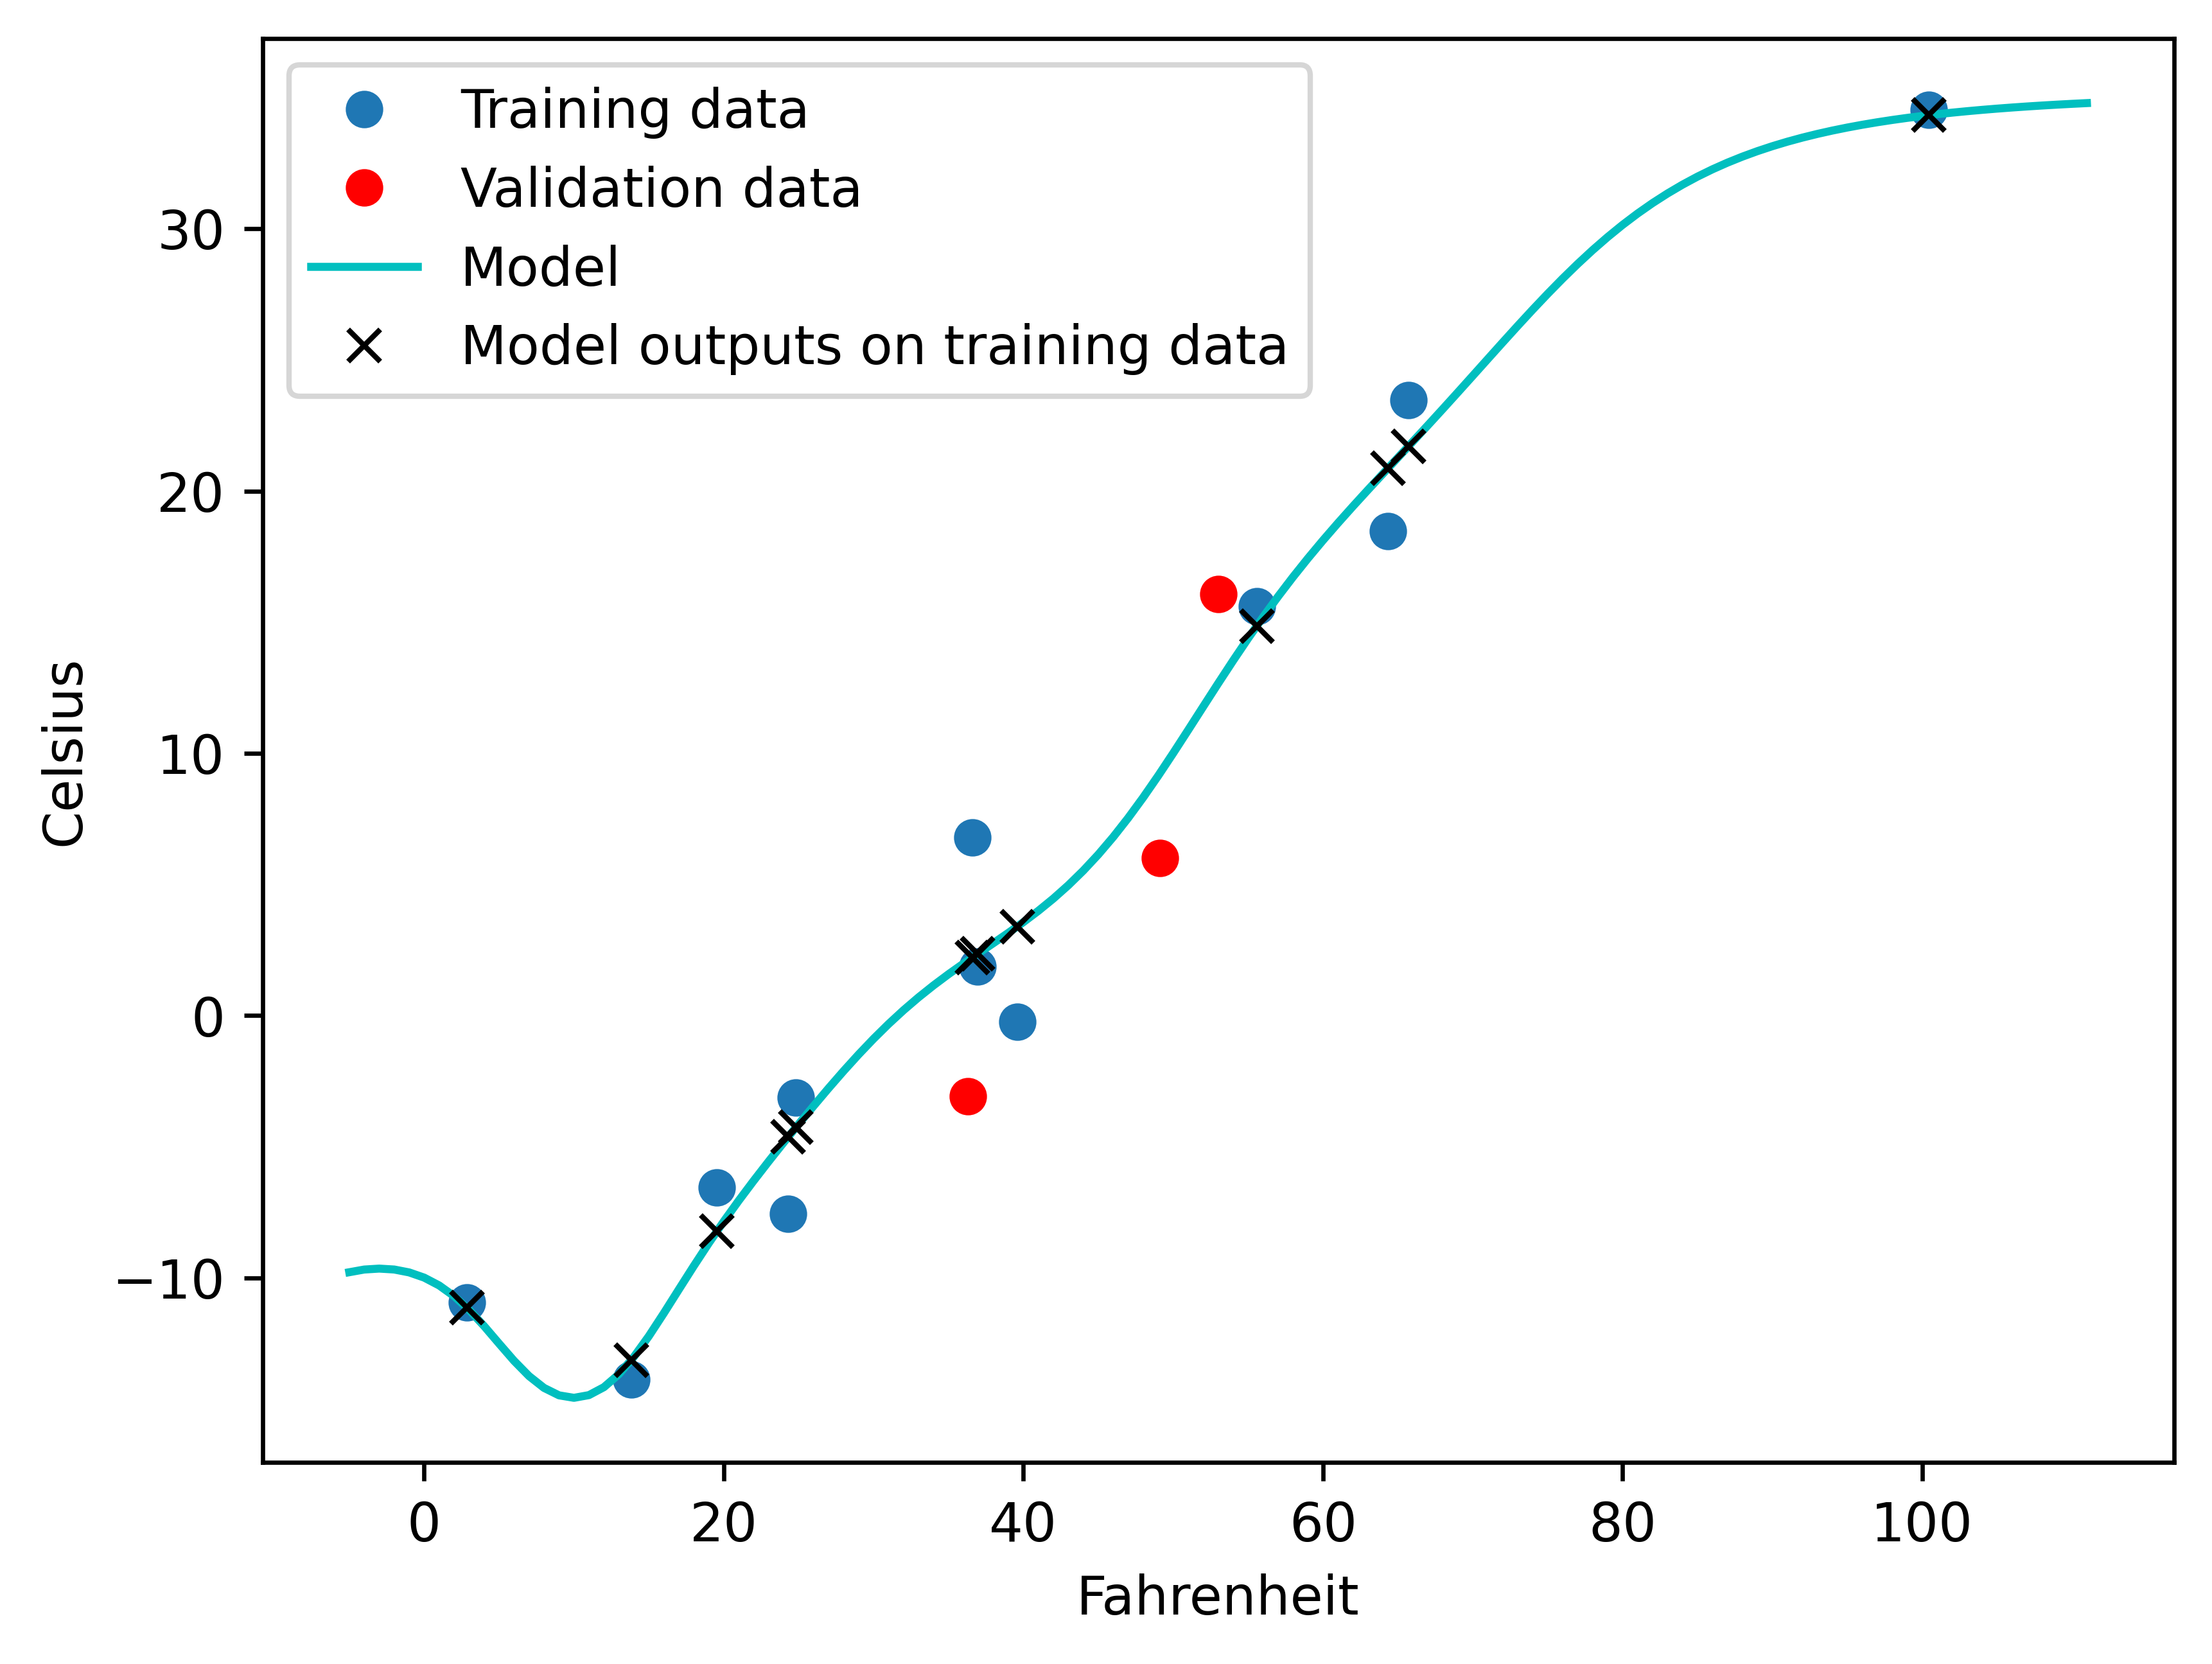

In [28]:
## Define a model
seq_model = nn.Sequential(nn.Linear(1,21),  ## Define a linear input layer with 13 hidden units
                          nn.Tanh(), ## Use the hyperbolic tangent activation function
                          nn.Linear(21,13), ## Define the output layer to return a single output
                          nn.Tanh(), ## Use the hyperbolic tangent activation function
                          nn.Linear(13,1) ## Define the output layer to return a single output
                         )

## Pick an optimizer and learning rate
optimizer = optim.SGD(
    seq_model.parameters(), ## What to optimize
    lr = 1e-3 ## Learning rate
)

## Train the model
training_loop(n_epochs = 6000,
              optimizer = optimizer,
              model = seq_model, 
              loss_fn = nn.MSELoss(), ## Use a built in loss function 
              t_u_train = t_un_train, 
              t_u_val = t_un_val,
              t_c_train = t_c_train, 
              t_c_val = t_c_val)

## Visiualizing the results
t_range = torch.arange(-5., 112.).unsqueeze(1) ## Grab temps between -5F and 112F
fig = plt.figure(dpi=600)
plt.xlabel("Fahrenheit")
plt.ylabel("Celsius")
plt.plot(t_u_train, t_c_train, 'o', label='Training data')
plt.plot(t_u_val, t_c_val, 'or', label='Validation data')
plt.plot(t_range.numpy(), seq_model(0.1 * t_range).detach().numpy(), 'c-', label='Model')
plt.plot(t_u_train, seq_model(t_un_train).detach().numpy(), 'kx', label='Model outputs on training data')
plt.legend()
plt.show()

In [ ]:
## Define a model
seq_model = nn.Sequential(nn.Linear(1,45),  ## Define a linear input layer with 13 hidden units
                          nn.Tanh(), ## Use the hyperbolic tangent activation function
                          nn.Linear(1,21),  ## Define a linear input layer with 13 hidden units
                          nn.Tanh(), ## Use the hyperbolic tangent activation function
                          nn.Linear(21,13), ## Define the output layer to return a single output
                          nn.Tanh(), ## Use the hyperbolic tangent activation function
                          nn.Linear(13,1) ## Define the output layer to return a single output
                         )

## Pick an optimizer and learning rate
optimizer = optim.SGD(
    seq_model.parameters(), ## What to optimize
    lr = 1e-3 ## Learning rate
)

## Train the model
training_loop(n_epochs = 6000,
              optimizer = optimizer,
              model = seq_model, 
              loss_fn = nn.MSELoss(), ## Use a built in loss function 
              t_u_train = t_un_train, 
              t_u_val = t_un_val,
              t_c_train = t_c_train, 
              t_c_val = t_c_val)

## Visiualizing the results
t_range = torch.arange(-5., 112.).unsqueeze(1) ## Grab temps between -5F and 112F
fig = plt.figure(dpi=600)
plt.xlabel("Fahrenheit")
plt.ylabel("Celsius")
plt.plot(t_u_train, t_c_train, 'o', label='Training data')
plt.plot(t_u_val, t_c_val, 'or', label='Validation data')
plt.plot(t_range.numpy(), seq_model(0.1 * t_range).detach().numpy(), 'c-', label='Model')
plt.plot(t_u_train, seq_model(t_un_train).detach().numpy(), 'kx', label='Model outputs on training data')
plt.legend()
plt.show()